<a href="https://colab.research.google.com/github/juliolunamoreno/Challenge-2.0/blob/master/CalibratedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibrated classifier: Is Logistic regression always well calibrated?

### Rationale

In the ``Scikit-learn`` documentation [example](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py) about calibration it is tested the logistic regresion againts non linear and generative classifers. It is found that logistic regression has a much better performance on brier score. Nonetheless this is highly dependant on the linear separability of the data, since when this condition is not fulfilled, not only performance metrics but calibration will not be as high as we would want.


### Methodology

1. We are to train and evaluate different classfiers on the Kaggle's ```give me some credit```dataset which is not linearly separable. In order to test the calibration we are to use the brier score which is defined as follows as the mean squared error of the binary predictions.

2. We are to use Platt scaling to test if we can improve the calibration of every classifier tested.

### Conclusions

In this project, we explored the importance of calibrating classifiers to obtain reliable probability estimates that can be interpreted as confidence levels.

We found that it is not a general rule that linear model or model that optimize the logss cost function have always a goood calibration and that it is closely related to model performance.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve, brier_score_loss
from scipy.stats import ks_2samp
from sklearn.ensemble import RandomForestClassifier


import umap

import warnings;warnings.filterwarnings("ignore")

plt.style.use('seaborn-whitegrid')

In [8]:
df = pd.read_csv("data/cs-training.csv").drop('Unnamed: 0', axis = 1)

In [9]:
features = [
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans', 
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

target_column = ["SeriousDlqin2yrs"]

In [10]:
train_df, test_df =train_test_split(df, test_size = .3, random_state = 42)

In [73]:
%%time
visualizer_linear = Pipeline([("imputer",SimpleImputer()), ("scaler",StandardScaler()), ("decomposer",PCA())]).fit(train_df[features])
X2D_linear = visualizer_linear.transform(train_df[features])

visualizer_umap = Pipeline([("imputer",SimpleImputer()), ("scaler",StandardScaler()), ("decomposer",umap.UMAP(n_neighbors = 50))]).fit(train_df[features])
X2D_umap = visualizer_umap.transform(train_df[features])

CPU times: user 3min 51s, sys: 8.07 s, total: 4min
Wall time: 39.3 s


## Features visualization on 2D space

We clearly see that the dataset is far from being linearly separable, this may indeed be confirmed by the low score on PCA which is a linear projection method. Even when trying to project the data using manifold approaches it seems like the positive and negative cases seem to be very overlaped. This will make difficult for a linear model to have not only good performance metrics but calibrated probabilities.

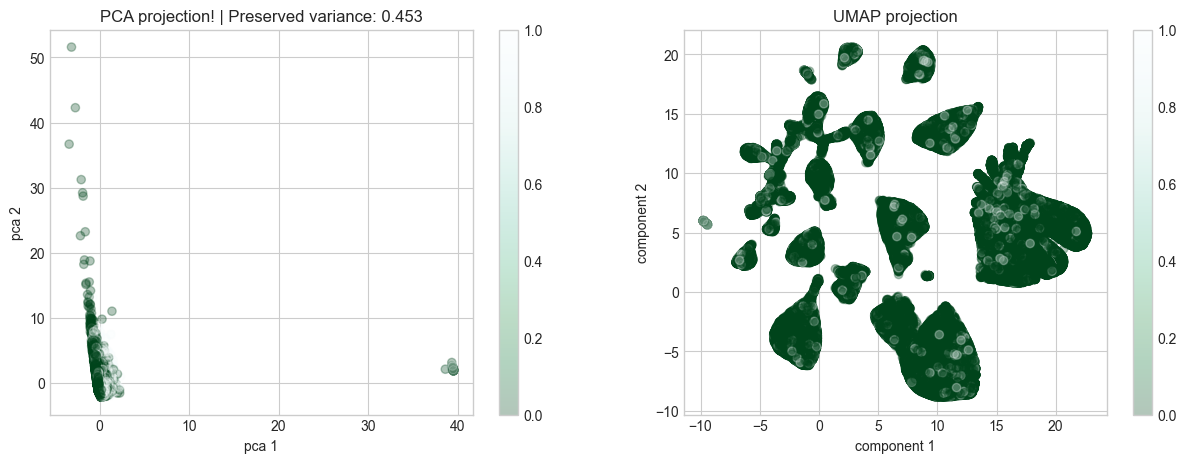

In [74]:
# Linear and non linear projections
fig, ax = plt.subplots(1,2, figsize = (15,5))
p1 = ax[0].scatter(X2D_linear[:,0], X2D_linear[:,1], c = train_df[target_column].values,cmap = "BuGn_r", alpha = .3)
p2 = ax[1].scatter(X2D_umap[:,0], X2D_umap[:,1], c = train_df[target_column].values,cmap = "BuGn_r", alpha = .3)

ax[0].set_title(f"PCA projection! | Preserved variance: {round(visualizer_linear['decomposer'].explained_variance_ratio_[:2].sum(),3)}")
ax[0].set_xlabel("pca 1")
ax[0].set_ylabel("pca 2")

ax[1].set_title(f"UMAP projection")
ax[1].set_xlabel("component 1")
ax[1].set_ylabel("component 2")

fig.colorbar(p1, orientation='vertical')
fig.colorbar(p2, orientation='vertical');

## Performance and model calibration

1. ROC curve shows that the models that have better performance, have also good calibration i.e. a linear model will not have a good calibration unless it has also a good performance.
2. Manifold projection did not improve performance nor calibration.

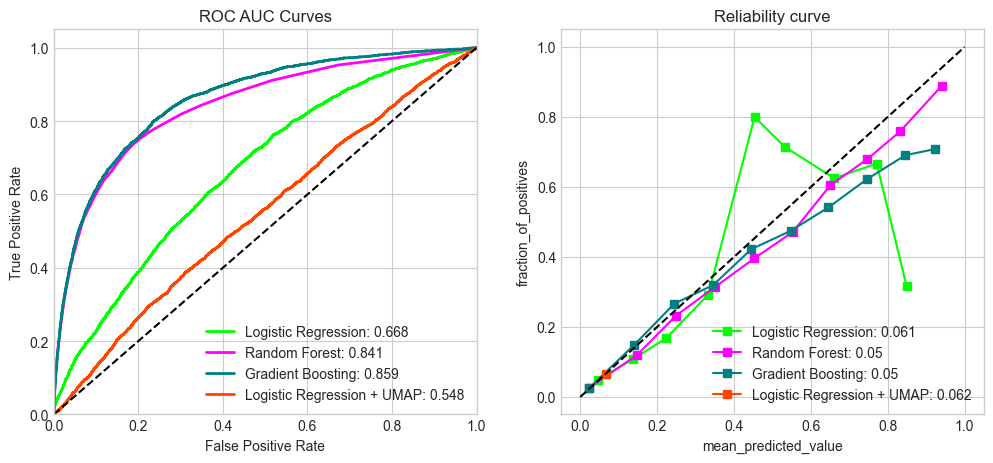

In [75]:
# Define a list of classifiers to test
classifiers = [
    ('Logistic Regression', Pipeline([("imputer",SimpleImputer()), ("model",LogisticRegression(random_state=42))])),
    ('Random Forest', Pipeline([("imputer",SimpleImputer()), ("model",RandomForestClassifier(random_state=42))])),
    ('Gradient Boosting', XGBClassifier(random_state=42)),
    ('Logistic Regression + UMAP', Pipeline([("imputer",SimpleImputer()),("projector", umap.UMAP()), ("model",LogisticRegression(random_state=42))])),
    
]

# Initialize lists to store results
brier_scores = {}
roc_auc_scores = {}
colors = ["lime", "magenta", "teal", "orangered"]
i = 0

fig, ax = plt.subplots(1,2, figsize = (12,5))
# Iterate through classifiers
for name, classifier in classifiers:
    # Fit the classifier
    classifier.fit(train_df[features], train_df[target_column])
    
    # Predict probabilities
    prob_pos = classifier.predict_proba(test_df[features])[:, 1]
    
    # Calculate Brier score
    
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(test_df[target_column], prob_pos)
    roc_auc_scores[name] =auc(fpr, tpr)

    # Calculate calibration curve and brier score
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_df[target_column], prob_pos, n_bins=10)
    brier_scores[name] =brier_score_loss(test_df[target_column], prob_pos)
    


    
    
    # Plot curves
    ax[0].plot(fpr, tpr, lw=2, label=f"{name}: {round(roc_auc_scores[name],3)}", color = colors[i])
    ax[1].plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}: {round(brier_scores[name],3)}", color = colors[i])
    i+=1
    
ax[0].plot([0, 1], [0, 1], color="black", linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title(f"ROC AUC Curves")
ax[0].legend()

ax[1].plot([0,1], [0,1], color = 'black', linestyle = '--')
ax[1].legend()
ax[1].set_xlabel('mean_predicted_value')
ax[1].set_ylabel('fraction_of_positives')
ax[1].set_title('Reliability curve');






## Predictions distribution
We see that predictions distribution for the umap embeddings models has affected the model such that the range of predictions is restricted to a very low range.

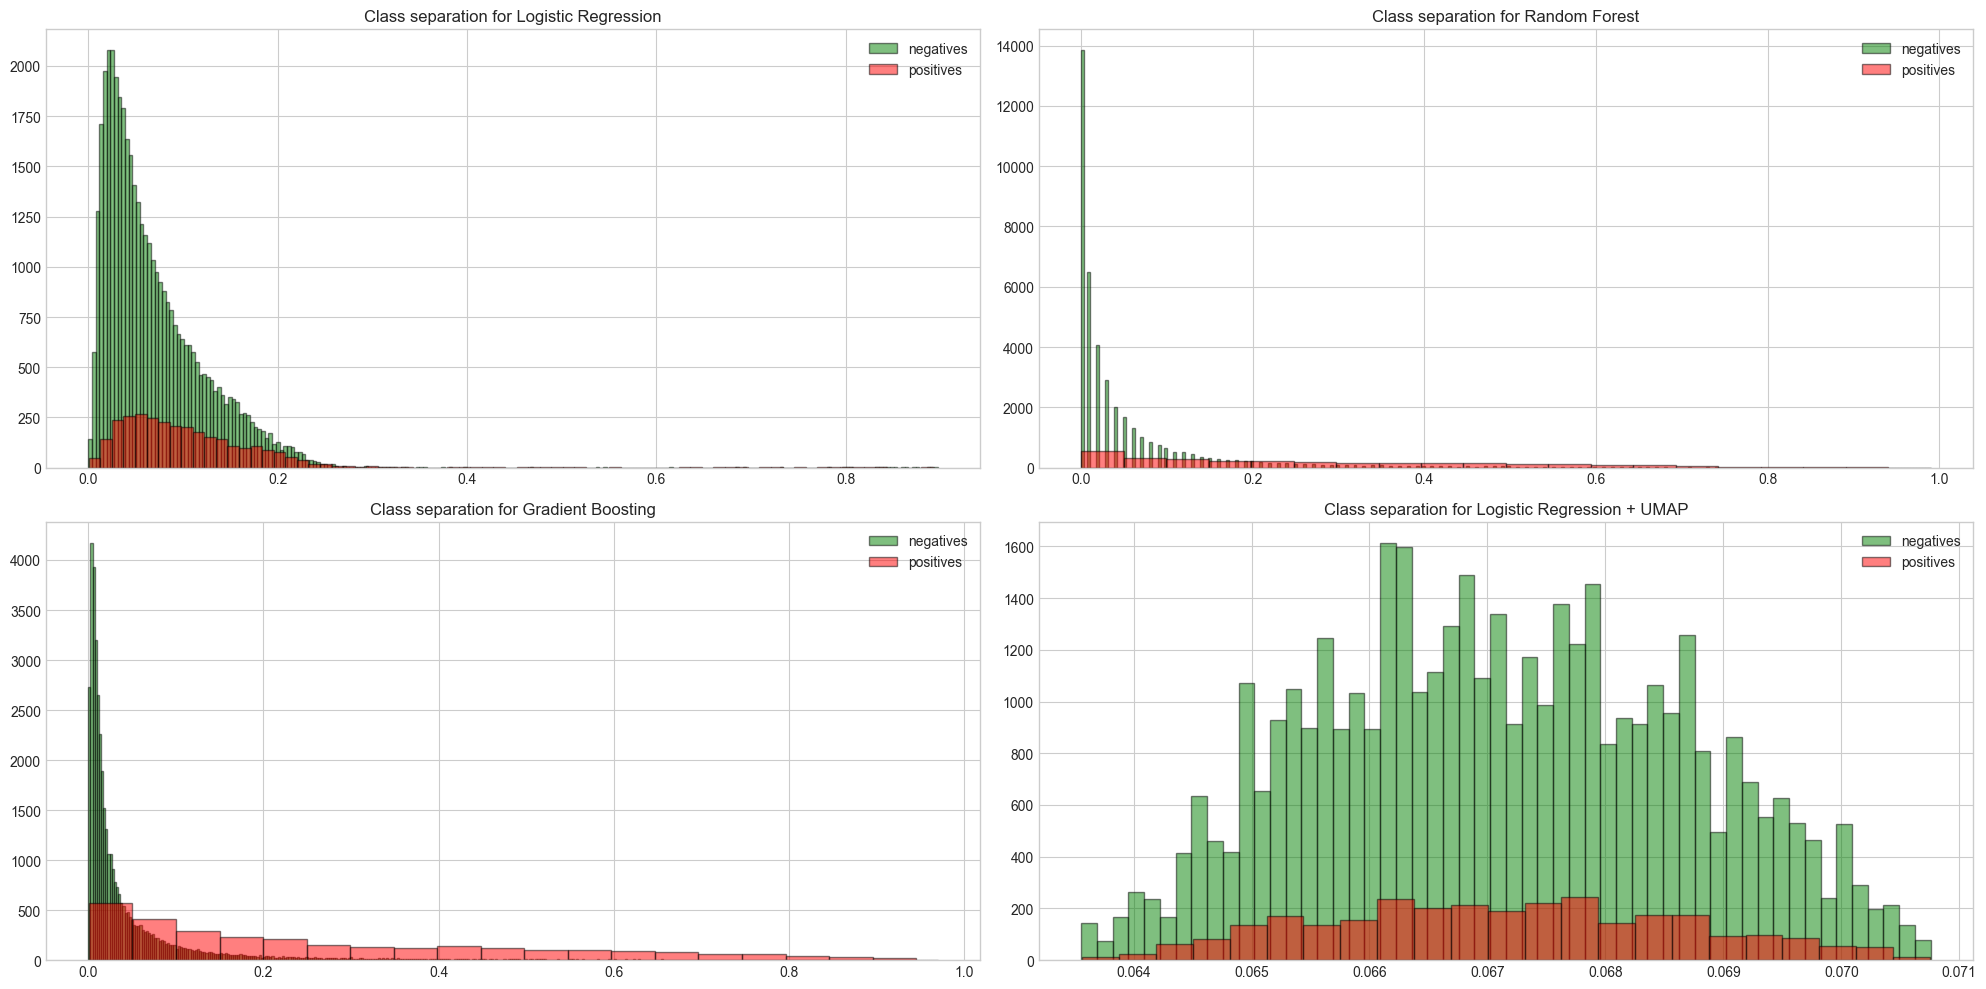

In [98]:

fig, ax = plt.subplots(2,2, figsize = (20,10))
k = 0
    
for i in range(2):
    for j in range(2):
        clf = classifiers[k]
        clf[1].fit(train_df[features], train_df[target_column])
        prob_pos = clf[1].predict_proba(test_df[features])[:, 1]
        ax[i,j].hist(prob_pos[test_df.SeriousDlqin2yrs==0], color = 'green', alpha = .5, edgecolor = 'black',  bins = 'auto', label = "negatives")
        ax[i,j].hist(prob_pos[test_df.SeriousDlqin2yrs==1], color = 'red', alpha = .5, edgecolor = 'black',  bins = 'auto', label = "positives")
        ax[i,j].set_title(f"Class separation for {clf[0]}") 
        ax[i,j].legend()
   
        k+=1
plt.tight_layout();


### Applying calibration (platt scalling and isotonic regression) to Logistic regression

Since we found that our linear model is not only performing poorly but also having a low calibration we are to test if applying some calibration strategy may help.

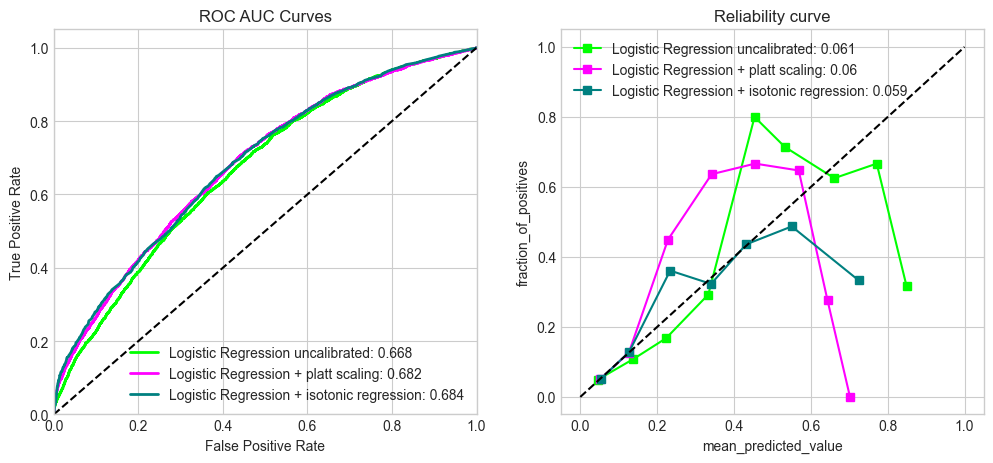

In [109]:
# Define a list of classifiers to test
base_estimator = Pipeline([("imputer",SimpleImputer()), ("model",LogisticRegression(random_state=42))])
classifiers = [
    ('Logistic Regression uncalibrated', base_estimator),
    ('Logistic Regression + platt scaling', CalibratedClassifierCV(estimator=base_estimator, cv = 3, method="sigmoid")),
    ('Logistic Regression + isotonic regression', CalibratedClassifierCV(estimator=base_estimator, cv = 3, method="isotonic"))
]

# Initialize lists to store results
brier_scores = {}
roc_auc_scores = {}
predictions ={}

colors = ["lime", "magenta","teal"]
i = 0

fig, ax = plt.subplots(1,2, figsize = (12,5))
# Iterate through classifiers
for name, classifier in classifiers:
    # Fit the classifier
    classifier.fit(train_df[features], train_df[target_column])
    
    # Predict probabilities
    prob_pos = classifier.predict_proba(test_df[features])[:, 1]
    predictions[name] =prob_pos
    
    # Calculate Brier score
    
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(test_df[target_column], prob_pos)
    roc_auc_scores[name] =auc(fpr, tpr)

    # Calculate calibration curve and brier score
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(test_df[target_column], prob_pos, n_bins=10)
    brier_scores[name] =brier_score_loss(test_df[target_column], prob_pos)
    


    
    
    # Plot curves
    ax[0].plot(fpr, tpr, lw=2, label=f"{name}: {round(roc_auc_scores[name],3)}", color = colors[i])
    ax[1].plot(mean_predicted_value, fraction_of_positives, "s-", label=f"{name}: {round(brier_scores[name],3)}", color = colors[i])
    i+=1
    
ax[0].plot([0, 1], [0, 1], color="black", linestyle='--')
ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title(f"ROC AUC Curves")
ax[0].legend()

ax[1].plot([0,1], [0,1], color = 'black', linestyle = '--')
ax[1].legend()
ax[1].set_xlabel('mean_predicted_value')
ax[1].set_ylabel('fraction_of_positives')
ax[1].set_title('Reliability curve');




